In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm
from itertools import product

In this example, we will build a zero-dimensional model. Namely, we will find the Hartree-Fock groundstate solution for a diatomic molecule with onsite and nearest-neighbor interactions.

We start by writing the non-interacting Hamiltonian. The minimal tight-binding model has the following Hamiltonian:
$$
 H_0 = c_L^{\dagger} c_R + h.c.
$$
which we can rewrite in following matrix representation:
$$
H_0 = \left(c_L^{\dagger}~c_R^{\dagger}\right) \left(\begin{array}{cc}
    0 & \mathbb{1}\\
    \mathbb{1} & 0
\end{array}\right)
\left(\begin{array}{c}
    c_L\\
    c_R
\end{array}\right)
$$
where $\mathbb{1}$ is a $2\times 2$ identity matrix.

In [86]:
# Just writing the Hamiltonian above in numpy
hamiltonian_0 = np.block([
    [0 * np.eye(2), np.eye(2)],
    [np.eye(2), 0 * np.eye(2)]
])
# Here we add a dummy index because that is interpreted as a Γ-point calculation.
hamiltonian_0 = np.expand_dims(hamiltonian_0, axis=0)

We can naturally compute the eigenvalues for inspection.

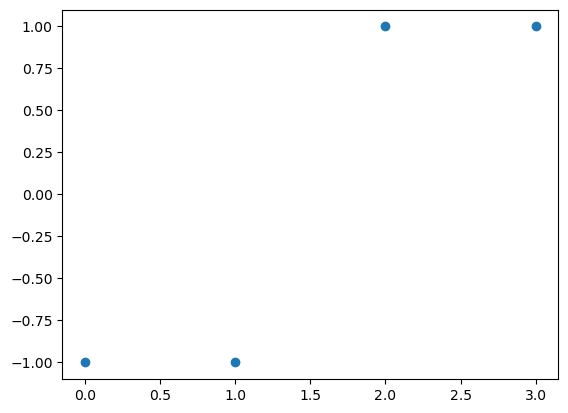

In [85]:
vals, vecs = np.linalg.eigh(hamiltonian_0[0])
plt.plot(vals, 'o')
plt.show()

We now move to an eigenvalue calculation of the Hartree-Fock solution. The workflow is rather simple:
* Generate a random guess.
* Run the self-consistent loop.
* Diagonalize the mean-field Hamiltonian.

In [91]:
def compute_vals(
    H_int,
    hamiltonian_0=hamiltonian_0,
    filling=2,
    tol=1e-5,
    mixing=0.01,
    order=10,
    guess=None
):
    # Generate random guess with same shape as the Hamiltonian.
    guess = np.random.rand(*hamiltonian_0.shape) * np.exp(1j * 2 * np.pi * np.random.rand(*hamiltonian_0.shape))

    # Run SCF loop to find groundstate Hamiltonian.
    h = hf.find_groundstate_ham(
        H_int=H_int,
        filling=filling,
        hamiltonians_0=hamiltonian_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Diagonalize groundstate Hamiltonian.
    vals, vecs = np.linalg.eigh(h)
    # Extract Fermi energy.
    E_F = utils.get_fermi_energy(vals, filling)
    return vals - E_F

And then we use this workflow to compute the phase diagram. We consider an interacting Hamiltonian with onsite and nearest-neighbor interactions:
\begin{align}
H_{int} = \sum_i U_i n_i n_i + \sum_{\langle i, j \rangle} V_{ij} n_i n_j\\
= \sum_i U_i n_{i\uparrow} n_{i\downarrow} + \sum_{\langle i, j \rangle} V_{ij} n_i n_j
\end{align}
where from the first to the second line we removed the terms that are not allowed by the exclusion principle. These are however taken care of by the algorithm, so we in fact just need to provide $U_i$ and $V_{ij}$. We simplify the Hamiltonian further as:
\begin{align}
H_{int} = U \sum_i n_{i\uparrow} n_{i\downarrow} + V_{ij} \sum_{\langle i, j \rangle} n_i n_j~.
\end{align}
Thus, the we just need to pass to the algorithm the matrix
$$
H_{int} =
\left(\begin{array}{cccc}
    U & U & V & V\\
    U & U & V & V\\
    V & V & U & U\\
    V & V & U & U
\end{array}\right)~.
$$

We thus sweep these parameters and see how the eigenvalues evolve.

In [99]:
def compute_phase_diagram(
    Us,
    Vs,
    tol=1e-5,
    mixing=0.1,
    order=5,
):
    # onsite interactions
    onsite_int = np.block(
        [[np.ones((2, 2)), np.zeros((2, 2))], [np.zeros((2, 2)), np.ones((2, 2))]]
    )
    onsite_int = np.expand_dims(onsite_int, axis=0)
    # Nearest-neighbor interactions
    nn_int = np.block(
        [[np.zeros((2, 2)), np.ones((2, 2))], [np.zeros((2, 2)), np.zeros((2, 2))]]
    )
    nn_int = np.expand_dims(nn_int, axis=0)
    vals = []
    for U in tqdm(Us):
        gap_U = []
        vals_U = []
        for V in Vs:
            H_int = U * onsite_int + V * nn_int
            _vals = compute_vals(
                H_int=H_int,
                tol=tol,
                mixing=mixing,
                order=order,
            )
            vals_U.append(_vals)
        vals.append(vals_U)
    return np.asarray(vals)

In [ ]:
# Interaction strengths
Us = np.linspace(0, 5, 20, endpoint=True)
Vs = np.linspace(0, 1, 20, endpoint=True)
vals = compute_phase_diagram(Us, Vs, tol=1e-5)

 65%|██████▌   | 13/20 [00:34<00:32,  4.62s/it]

In [94]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(
        vals=(["Us", "Vs", "n"], vals[:,:,0,:]),
    ),
    coords=dict(Us=Us, Vs=Vs, n=np.arange(vals.shape[-1])),
)

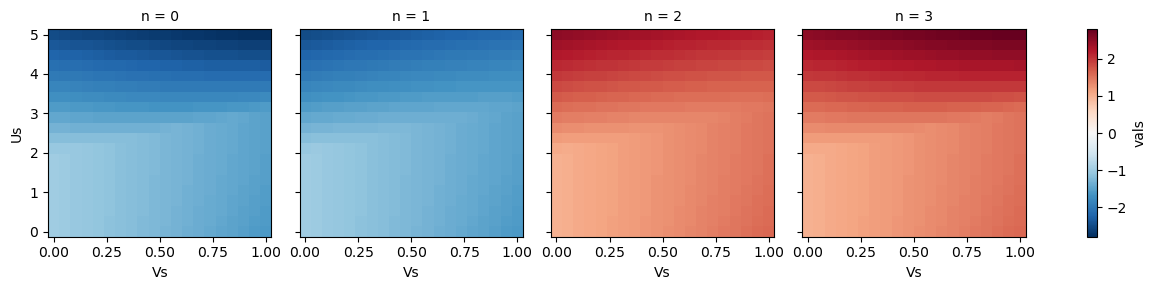

In [95]:
ds.vals.plot(col='n')
plt.show()

In [97]:
ds.to_netcdf('./data/diatomic_molecule_example.nc')